In [9]:
import boto3

import pandas as pd 
import numpy as np
import holidays

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/train.csv'
file_key_2 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/test.csv'
file_key_3 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
train['date'] = pd.to_datetime(train['date'])

test = pd.read_csv(file_content_stream_2)
test['date'] = pd.to_datetime(test['date'])

submission = pd.read_csv(file_content_stream_3)

def get_holidays(df):
    years_list = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

    holiday_US = holidays.CountryHoliday('US', years = years_list)
    holiday_dict = holiday_US.copy()

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df.drop(columns = ['holiday_name'])


def feature_engineer(df):
    
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
#     new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
#     new_df["day_cos"] = np.cos(new_df['day'] * (2 * np.pi / 12))
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x <= 3 else(1 if x == 4 else (2 if x == 5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    new_df["year"] = df["date"].dt.year
    
    return new_df

train = feature_engineer(train)
test = feature_engineer(test)

train = get_holidays(train)
test = get_holidays(test)

train.loc[((train['date'] >= '2017-09-27') & (train['date'] <= '2018-06-12')), 'sleep_hours'] = train.loc[((train['date'] >= '2017-09-27') & (train['date'] <= '2018-06-12')), 'sleep_hours'] / 1.94 

X = train.drop(columns = ['date', 'sleep_hours', 'year'], axis = 1)
Y = train['sleep_hours']

test = test.drop(columns = ['date', 'sleep_hours', 'year'], axis = 1)

train = train[train['date'] > '2015-07-20'].reset_index(drop = True)

In [10]:
train.head()

,date,sleep_hours,month,month_sin,day,day_sin,day_of_week,day_of_year,year,is_holiday
0,2015-07-21,7.850000,7,-0.5,21,-1.000000e+00,0,202,2015,0
1,2015-07-22,5.916667,7,-0.5,22,-8.660254e-01,0,203,2015,0
2,2015-07-23,6.916667,7,-0.5,23,-5.000000e-01,0,204,2015,0
3,2015-07-24,6.450000,7,-0.5,24,-4.898587e-16,1,205,2015,0
4,2015-07-25,7.783333,7,-0.5,25,5.000000e-01,2,206,2015,0


In [16]:
train_agg = pd.DataFrame(train.groupby(['month', 'day_of_week'])['sleep_hours'].mean()).reset_index()
train_agg.head(20)

,month,day_of_week,sleep_hours
0,1,0,6.527964
1,1,1,6.757709
2,1,2,6.895420
3,1,3,7.021891
4,2,0,6.520421
5,2,1,6.597471
6,2,2,7.201818
7,2,3,6.739332
8,3,0,6.743958
9,3,1,6.968603


(array([5., 7., 8., 2., 6., 4., 8., 3., 4., 1.]),
 array([6.41064033, 6.48975814, 6.56887595, 6.64799376, 6.72711158,
        6.80622939, 6.8853472 , 6.96446501, 7.04358282, 7.12270063,
        7.20181844]),
 <BarContainer object of 10 artists>)

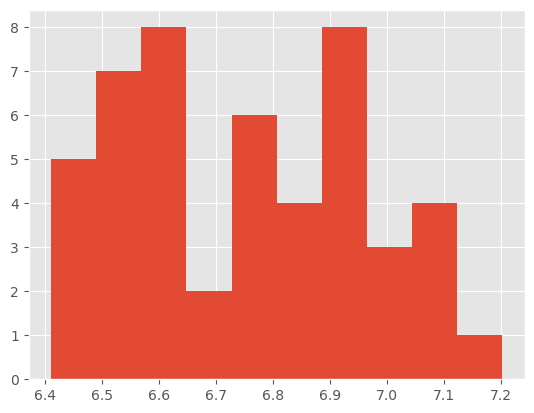

In [17]:
plt.hist('sleep_hours', data = train_agg)

In [18]:
test.head()

,month,month_sin,day,day_sin,day_of_week,day_of_year,is_holiday
0,1,0.5,1,0.500000,2,1,1
1,1,0.5,2,0.866025,3,2,0
2,1,0.5,3,1.000000,0,3,0
3,1,0.5,4,0.866025,0,4,0
4,1,0.5,5,0.500000,0,5,0


In [23]:
test_new = pd.merge(test[['month', 'day_of_week']], train_agg, on = ['month', 'day_of_week'], how = 'left')
test_new.head(10)

,month,day_of_week,sleep_hours
0,1,2,6.895420
1,1,3,7.021891
2,1,0,6.527964
3,1,0,6.527964
4,1,0,6.527964
5,1,0,6.527964
6,1,1,6.757709
7,1,2,6.895420
8,1,0,6.527964
9,1,0,6.527964


In [24]:
lasso_pred = pd.read_csv('lasso_baseline_optuna_submission.csv')
lasso_pred.head(10)

,date,sleep_hours
0,2022-01-01,6.850854
1,2022-01-02,6.959179
2,2022-01-03,6.633285
3,2022-01-04,6.633055
4,2022-01-05,6.632825
5,2022-01-06,6.632595
6,2022-01-07,6.740920
7,2022-01-08,6.849245
8,2022-01-19,6.629605
9,2022-01-20,6.629375


In [ ]:
submission['pred1'] = test_new['sleep']